In [1]:
from sklearn import model_selection, datasets
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = load_boston()
data_frame = DataFrame(data.data)
data_frame.columns = data.feature_names
data_frame['target'] = data.target

In [4]:
data.data[:,0]

array([  6.32000000e-03,   2.73100000e-02,   2.72900000e-02,
         3.23700000e-02,   6.90500000e-02,   2.98500000e-02,
         8.82900000e-02,   1.44550000e-01,   2.11240000e-01,
         1.70040000e-01,   2.24890000e-01,   1.17470000e-01,
         9.37800000e-02,   6.29760000e-01,   6.37960000e-01,
         6.27390000e-01,   1.05393000e+00,   7.84200000e-01,
         8.02710000e-01,   7.25800000e-01,   1.25179000e+00,
         8.52040000e-01,   1.23247000e+00,   9.88430000e-01,
         7.50260000e-01,   8.40540000e-01,   6.71910000e-01,
         9.55770000e-01,   7.72990000e-01,   1.00245000e+00,
         1.13081000e+00,   1.35472000e+00,   1.38799000e+00,
         1.15172000e+00,   1.61282000e+00,   6.41700000e-02,
         9.74400000e-02,   8.01400000e-02,   1.75050000e-01,
         2.76300000e-02,   3.35900000e-02,   1.27440000e-01,
         1.41500000e-01,   1.59360000e-01,   1.22690000e-01,
         1.71420000e-01,   1.88360000e-01,   2.29270000e-01,
         2.53870000e-01,

In [5]:
data_frame.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data.data, data.target, test_size = 0.25)


In [7]:
def H(X,left,right):
    return float(len(left)) / len(X) * left.var() + float(len(right)) / len(X) * right.var()

In [8]:
class Tree:
    class Node:
        def __init__(self, j =-1,t=-1, y_mean=0, depth=1):
            self.j = j
            self.t = t
            self.y_mean = y_mean
            self.left = None
            self.right = None
            self.depth = depth
    
    def __init__(self, max_depth=0):
        self.left = None
        self.right = None
        self.max_depth = max_depth
        self.root = self.Node()
 
    def _fit(self,node,X,y):  
        if node.depth != self.max_depth and y.var():
            cur_H = 0
            cur_j, cur_t = -1, -1
            for j in range(len(X[0])):
                for t in X[:,j]:
                    left = y[X[:, j] <  t]
                    right = y[X[:, j] >= t]
                    if (len(left) == 0):
                        continue
                    _H = H(X,left,right)
                    if cur_H == 0 or  _H < cur_H :
                        cur_H = _H
                        cur_j = j
                        cur_t = t
            node.j = cur_j
            node.t = cur_t
            left = X[:, node.j] < node.t
            right = X[:, node.j] >= node.t
            if len(X[right]) > 0 and len(X[left]) > 0: 
                node.right = self.Node(depth=node.depth + 1)
                node.left = self.Node(depth=node.depth + 1)
                self._fit(node.left,X[left],y[left])
                self._fit(node.right,X[right],y[right])
        else:
            node.y_mean = y.mean()
            
    def fit(self,X,y):
        self._fit(self.root,X,y)
        
    def split(self,X,j,t,y):
        left = X[:, j] <  t
        right = X[:, j] >= t
        return X[left], y[left], X[right], y[right]
    
    def _predict(self,X, node):
        if node.left is None:
            return node.y_mean
        l, l_ix, r, r_ix = self.split(X, node.j, node.t, np.arange(len(X)))
        y = np.zeros(len(X))
        y[l_ix] = self._predict(l, node.left)
        y[r_ix] = self._predict(r, node.right)
        return y
    def predict(self,X):        
        return self._predict(X, self.root)

In [9]:
tree = Tree(max_depth = 10)

In [10]:
tree.fit(X_train,y_train)

In [11]:
answer = tree.predict(X_test)

Сравнение с sclearn tree

In [12]:
mean_squared_error(y_test, answer)


23.02680677510974

In [13]:
DesTree = DecisionTreeRegressor(max_depth=10)
DesTree.fit(X_train, y_train)
DesAnswer = DesTree.predict(X_test)
mean_squared_error(y_test, DesAnswer)

12.858021967864341

In [14]:
arr = []
sklearn_arr = []
for d in range(2, 10):
    DesTree = DecisionTreeRegressor(max_depth=d)
    DesTree.fit(X_train, y_train)
    DesAnswer = DesTree.predict(X_test)
    sklearn_arr.append(mean_squared_error(y_test, DesAnswer)) 
    tree = Tree(max_depth = d)
    tree.fit(X_train,y_train)
    answer = tree.predict(X_test)
    MSE = mean_squared_error(y_test, answer)
    arr.append(MSE)

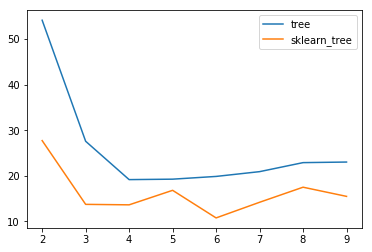

In [16]:
plt.plot(range(2, 10), arr, label='tree')
plt.plot(range(2, 10), sklearn_arr, label='sklearn_tree')
plt.legend(loc='best')
plt.show()

Таким образом, написанное дерево работает не намного хуже, чем из sclearn